# Ensemble models to Predict Crash Severity

#### This notebook contains our ensemble methods that predict the label, "Severity Score". Severity Score is a continuous value and is calculated using the following formula:
$$
\text{Severity Score} = 
(10 \times \text{K_People}) +
(6 \times \text{A_People}) +
(4 \times \text{B_People}) +
(2 \times \text{C_People}) +
(1.5 \times \text{Ped_Number}) +
(0.2 \times \text{Vehicle_Count})
$$

where K_people is persons killed, A_people is persons serverly injured, B_people is persons with visible injury, C_people is persons with non-visible injury, Ped_Number is number of pedestrains invovled, and Vehicle_Count is number of vehicles involved

In [25]:
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("crash_data.csv", low_memory=False)

In [3]:
df.shape

(1128862, 128)

In [4]:
keep_cols = [
    'Crash_Date','Crash_Military_Time','Intersection_Type','Area_Type',
    'Roadway_Alignment','Light_Condition','Weather_Condition',
    'Roadway_Surface_Condition','Roadway_Surface_Type',
    'Traffic_Control_Type','Traffic_Control_Status','Collision_Type',
    'Speed_Posted','Vehicle_Count','First_Harmful_Event','Crash_Severity',
    
    'Alcohol?', 'Unrestrained?', 'Distracted?', 'Drowsy?', 'Drug_Related?', 'Speed?',
    
    'K_People', 'A_People', 'B_People', 'C_People',
    'Pass_vehiclenumber', 'Ped_Number'
]
df = df[keep_cols].copy()

In [5]:
df.shape

(1128862, 28)

In [6]:
df.loc[:, 'Ped_Number'] = df['Ped_Number'].fillna(0).apply(pd.to_numeric, errors='coerce')

In [7]:
def calculate_severity_score(row):
    # Raw Severity Score
    return (
        10 * row['K_People'] +
        6 * row['A_People'] +
        4 * row['B_People'] +
        2 * row['C_People'] +
        1.5 * row['Ped_Number'] +
        0.2 * row['Vehicle_Count']
    )

In [8]:
df.loc[:, 'Severity_Score'] = df.apply(calculate_severity_score, axis=1)

In [9]:
df.loc[:, 'Normalized_Severity_Score'] = (df['Severity_Score'] / 400) * 100

In [10]:
df.shape

(1128862, 30)

In [11]:
severity_range = df['Severity_Score'].min(), df['Severity_Score'].max()
print(f"Range of Severity Score: {severity_range}")

Range of Severity Score: (0.2, 344.2)


In [12]:
normalized_severity_range = df['Normalized_Severity_Score'].min(), df['Normalized_Severity_Score'].max()
print(f"Range of Normalized Severity Score: {normalized_severity_range}")

Range of Normalized Severity Score: (0.05, 86.05)


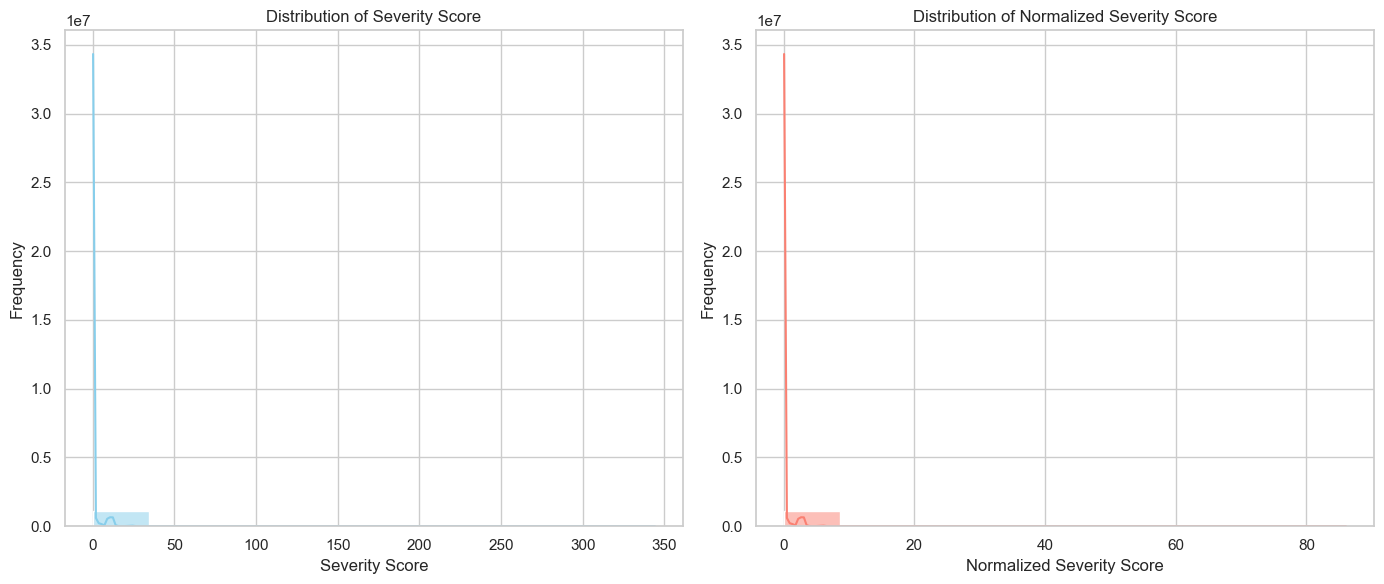

In [13]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the Severity Score
sns.histplot(df['Severity_Score'], bins=10, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Severity Score')
axes[0].set_xlabel('Severity Score')
axes[0].set_ylabel('Frequency')

# Plot for the Normalized Severity Score
sns.histplot(df['Normalized_Severity_Score'], bins=10, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Normalized Severity Score')
axes[1].set_xlabel('Normalized Severity Score')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
df['Crash_Date'] = pd.to_datetime(df['Crash_Date'])
df['day_of_week'] = df['Crash_Date'].dt.day_name()

In [15]:
def extract_hour(t):
    s = str(int(t)).zfill(4)
    return int(s[:2])
df['hour_of_day'] = df['Crash_Military_Time'].apply(extract_hour)

bins = [0, 6, 12, 18, 24]
labels = ['Night','Morning','Afternoon','Evening']
df['time_of_day'] = pd.cut(df['hour_of_day'], bins=bins, labels=labels, right=False)


In [16]:
def parse_max_speed(s):
    if pd.isna(s):
        return np.nan
    nums = [int(x) for x in re.findall(r'\d+', s)]
    return max(nums) if nums else np.nan

df['Speed_Posted_max'] = df['Speed_Posted'].apply(parse_max_speed)


In [17]:
df = df.drop(columns=['Crash_Date','Crash_Military_Time','Speed_Posted','hour_of_day'])

In [18]:
df.shape

(1128862, 30)

In [19]:
df.head()

,Intersection_Type,Area_Type,Roadway_Alignment,Light_Condition,Weather_Condition,Roadway_Surface_Condition,Roadway_Surface_Type,Traffic_Control_Type,Traffic_Control_Status,Collision_Type,...,A_People,B_People,C_People,Pass_vehiclenumber,Ped_Number,Severity_Score,Normalized_Severity_Score,day_of_week,time_of_day,Speed_Posted_max
0,1. Not at Intersection,Urban,1. Straight - Level,4. Darkness - Road Lighted,1. No Adverse Condition (Clear/Cloudy),1. Dry,"2. Blacktop, Asphalt, Bituminous",17. Highway Safety Corridor,1. Yes - Working,1. Rear End,...,0,0,0,NaN,0.0,0.4,0.10,Tuesday,Morning,60.0
1,1. Not at Intersection,Urban,1. Straight - Level,2. Daylight,1. No Adverse Condition (Clear/Cloudy),1. Dry,1. Concrete,6. Traffic Lanes Marked,1. Yes - Working,2. Angle,...,0,0,0,NaN,0.0,0.4,0.10,Tuesday,Afternoon,35.0
2,1. Not at Intersection,Rural,1. Straight - Level,4. Darkness - Road Lighted,1. No Adverse Condition (Clear/Cloudy),1. Dry,"2. Blacktop, Asphalt, Bituminous",6. Traffic Lanes Marked,1. Yes - Working,9. Fixed Object - Off Road,...,0,2,0,1,0.0,8.2,2.05,Saturday,Evening,55.0
3,1. Not at Intersection,Urban,1. Straight - Level,5. Darkness - Road Not Lighted,5. Rain,2. Wet,"2. Blacktop, Asphalt, Bituminous",6. Traffic Lanes Marked,6. No Traffic Control Device Present,1. Rear End,...,0,0,0,NaN,0.0,0.4,0.10,Saturday,Night,35.0
4,3. Three Approaches,Rural,3. Grade - Straight,2. Daylight,1. No Adverse Condition (Clear/Cloudy),1. Dry,"2. Blacktop, Asphalt, Bituminous",4. Stop Sign,1. Yes - Working,1. Rear End,...,0,0,0,NaN,0.0,0.4,0.10,Monday,Morning,55.0


In [20]:
df.to_csv('crash_data_score_ypdo.csv', index=False)

## Models

All models with include the following attributes: 'Intersection_Type','Area_Type','Roadway_Alignment', 'Light_Condition','Weather_Condition', 'Roadway_Surface_Condition','Roadway_Surface_Type', 'Traffic_Control_Type','Traffic_Control_Status', 'Collision_Type','First_Harmful_Event','day_of_week','time_of_day', 'Alcohol?', 'Unrestrained?', 'Distracted?', 'Drowsy?', 'Drug_Related?', 'Speed?'


### Pipeline -- PDO included

In [ ]:
df = pd.read_csv("crash_data_score_ypdo.csv")

In [ ]:
df.shape

In [ ]:
X = df.drop(columns=['Severity_Score'])
y = df['Severity_Score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.30,
    # stratify=y_enc,
    random_state=42
)

In [ ]:
numeric_feats = ['Vehicle_Count','Speed_Posted_max']
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_feats = [
    'Intersection_Type','Area_Type','Roadway_Alignment',
    'Light_Condition','Weather_Condition',
    'Roadway_Surface_Condition','Roadway_Surface_Type',
    'Traffic_Control_Type','Traffic_Control_Status',
    'Collision_Type','First_Harmful_Event',
    'day_of_week','time_of_day',
    
    'Alcohol?', 'Unrestrained?', 'Distracted?', 'Drowsy?', 'Drug_Related?', 'Speed?'
]
categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_feats),
    ('cat', categorical_pipe, categorical_feats)
])


## Random Forest

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)

model = Pipeline([
    ('preproc', preprocessor),
    ('rf', rf_regressor)
])

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [18]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

RMSE: 22.3346
R^2 Score: 0.1610


## Ensemble model -- RF, XGBoost, AdaBoost, LightGBM, CatBoost

In [34]:
rf   = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2,
                             n_estimators=100, random_state=42)

xgbr = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, min_child_weight=1,
                    random_state=42)

adbr = AdaBoostRegressor(learning_rate=0.1, n_estimators=50, random_state=42)

lgbr = LGBMRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)

catr = CatBoostRegressor(learning_rate=0.1, max_depth=3, n_estimators=100,
                         verbose=0, random_state=42, thread_count=1)

In [35]:
ensemble_reg = VotingRegressor(
    estimators=[('rf', rf), ('xgb', xgbr), ('ada', adbr), ('lgb', lgbr),],
    n_jobs=-1
)

In [36]:
model = Pipeline([
    ('preproc', preprocessor),
    ('clf', ensemble_reg)
])

In [37]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 790203, number of used features: 157
[LightGBM] [Info] Start training from score 13.084352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Vehicle_Count',
                                                   'Speed_Posted_max']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Intersection_...
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=3,
                                                           max_leaves=None,
                                                           min_child_weight=1,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=100,
                                                           n_jobs=None,
                                                           num_parallel_tree=None, ...)),
                                             ('ada',
                                              AdaBoostRegressor(learning_rate=0.1,
                                                                random_state=42)),
                                             ('lgb',
                                              LGBMRegressor(max_depth=3,
                                                            random_state=42))],
                                 n_jobs=-1))])

In [38]:
y_pred = model.predict(X_test)

/home/svj4hk/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [39]:
# evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 22.5510
R² Score: 0.1447
